In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gudhi as gd
import json

from glob import glob
import os
import tifffile as tf

from scipy import ndimage
from sklearn import manifold, cluster, decomposition, preprocessing
import persim

In [2]:
def pers2numpy(pers):
    bd = np.zeros((len(pers), 3), dtype=float)
    for i in range(len(bd)):
        bd[i, 0] = pers[i][0]
        bd[i, 1:] = pers[i][1]
    return bd

def get_diagrams(jsonfiles, ndims, remove_inf = False):
    # diag[j-th cell][k-th dimension]
    diags = [ [np.empty((0,2)) for k in range(ndims)] for j in range(len(jsonfiles))]

    for j in range(len(jsonfiles)):
        
        if jsonfiles[j] is not None:
            with open(jsonfiles[j]) as f:
                diag = [tuple(x) for x in json.load(f)]
            diag = pers2numpy(diag)
        
            for k in range(ndims):
                diags[j][k] = diag[diag[:,0] == k, 1:]
    
    if remove_inf:
        for j in range(len(diags)):
            for k in range(ndims):
                diags[j][k]  = np.atleast_2d(diags[j][k][np.all(diags[j][k] < np.inf, axis=1), :].squeeze())

    return diags

def save_dmatrix(mtrx, filename):
    N = len(mtrx)
    dflat = mtrx[np.triu_indices(N, k=1)]
    pd.Series(dflat).to_csv(filename, index=False, header=None)
    print(filename)

    return dflat

In [6]:
stepsize, PP, bw = 3,6,10
ndims = 3
wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
gsrc = '../sublevel/'
ksrc = '../kde/'
sample = 'D2'

ksrc += sample + os.sep
gsrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
transcriptomes = np.asarray(list(metatrans['gene']))

TT = ['GLYMA_05G092200','GLYMA_17G195900']
tidxs = np.array([np.argwhere(transcriptomes == TT[i])[0][0] for i in range(len(TT))])
tidxs

dst = '../distance/{}/{}_vs_{}_all/'.format(sample, *transcriptomes[tidxs])
if not os.path.isdir(dst):
    os.mkdir(dst)

In [5]:
focus = pd.read_csv('../data/D2_data/scattersutton.csv')
focus = focus[ focus['Bact'] == 'Infected' ]
print(focus.shape)

metafocus = np.zeros( (len(focus),1+metacell.shape[1]) )
for i in range(len(metafocus)):
    foo = metacell[metacell['orig_cellID'] == focus.iloc[i,0]].iloc[0,:]
    metafocus[i,0] = foo.name
    metafocus[i,1:] = foo.values

transfocus = transcell.loc[tidxs, metacell.loc[metafocus[:,0].astype(int), 'ndimage_cellID'].values.astype(str)]
ratios = (transfocus/np.sum(transfocus.values)).values
#ratios = transfocus.values/np.sum(transfocus.values, axis=1).reshape(-1,1)
print('Max ratio:\t', 100*np.max(ratios), '%')
transfocus

(968, 5)
Max ratio:	 0.24671835679793241 %


,742,842,2052,1145,896,2152,558,751,746,236,...,303,1782,1724,1571,1583,1454,2430,1143,752,513
26,249,317,581,307,195,1026,529,686,340,694,...,438,406,187,183,271,241,62,152,396,806
85,363,1239,1022,572,933,1182,531,1808,975,1305,...,228,156,48,62,107,131,49,86,138,371


In [20]:
filenames = sorted(glob(dst + '*_all_bottleneck_*.csv'))
matrices = [ None for i in range(len(filenames)) ]
for i in range(len(filenames)):
    matrices[i] = np.loadtxt(filenames[i], delimiter=',')
bottleneck = np.vstack(matrices)
bottleneck = bottleneck + bottleneck.T

In [29]:
img = bottleneck.copy().astype(np.uint8)
img = ndimage.uniform_filter(img, size=9, mode='reflect')
#img = ndimage.median_filter(img, size=9, mode='reflect')

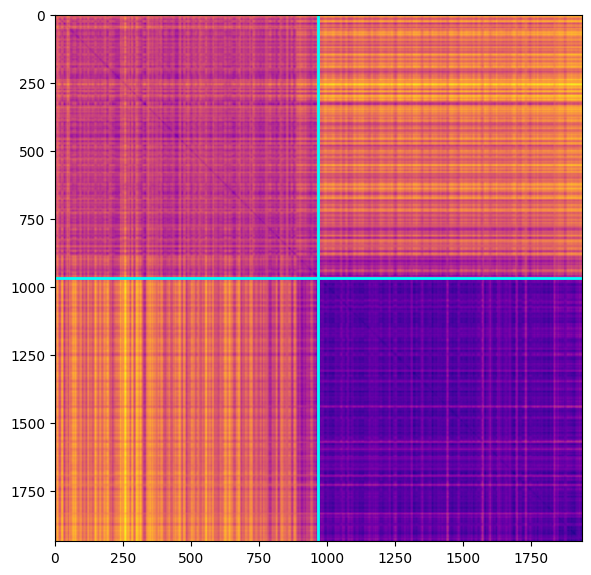

In [31]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].imshow(img, cmap='plasma')
ax[i].axhline(transfocus.shape[1], c='cyan', lw=2)
ax[i].axvline(transfocus.shape[1], c='cyan', lw=2)

fig.tight_layout();

In [16]:
np.sort(maxlife[:,:,2].astype(int).ravel())

array([ 22,  23,  23, ..., 231, 232, 232])

In [27]:
maxx

5.735956040648034e-09

In [29]:
diagh = [ [ None for k in range(ndims) ] for i in range(np.sum(ratios > 0)) ]

counter = 0
for i in range(len(diags)):
    for j in np.nonzero(ratios[i] > 0)[0]:
        for k in range(len(diags[i][j])):
            diagh[counter][k] = diags[i][j][k]
        counter += 1

print(len(diagh), len(diagh[0]), sep='\t')

1936	3


In [40]:
initrow = 10
endrow = 100

bottleneck = np.zeros((endrow - initrow, len(diagh)))

ix = 0
for i in range(initrow, endrow, 1):
    for j in range(i+1, bottleneck.shape[1]):
        dk = np.zeros(ndims)
        for k in range(len(dk)):
            if (len(diagh[i][k]) > 0) | (len(diagh[j][k]) > 0):
                dk[k] = persim.bottleneck(diagh[i][k], diagh[j][k], matching=False)
                #dk[k] = ix*j
        bottleneck[ix,j] = np.max(dk)
    ix += 1

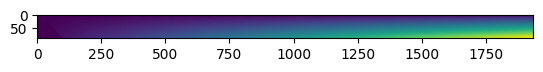

In [41]:
plt.imshow(bottleneck.astype(int));

In [107]:
filename = dst + dst.split(os.sep)[-2] + '_bottleneck_{:05d}_{:05d}.csv'.format(initrow, endrow)
filename

'../distance/D2/GLYMA_05G092200_vs_GLYMA_17G195900_all/GLYMA_05G092200_vs_GLYMA_17G195900_all_bottleneck_00000_00002.csv'

In [109]:
pd.DataFrame(bottleneck).to_csv(filename, index=False, header=None)

In [ ]:
def save_dmatrix(mtrx, filename):
    N = len(mtrx)
    dflat = mtrx[np.triu_indices(N, k=1)]
    pd.Series(dflat).to_csv(filename, index=False, header=None)
    print(filename)

    return dflat

In [19]:
# Bottleneck

h0, h1 = bottleneck_matrix(diag0, diag1, gd.bottleneck_distance)
dmatrix = np.maximum(h0, h1)
filename = tsrc + transcriptomes[tidx] + '_-_' + level + 'level_bottleneck.csv'
dflat = save_dmatrix(dmatrix, filename)

../gd_trans/D2/GLYMA_06G090100_-_superlevel_bottleneck.csv


In [13]:
N = len(jsonfiles)
A = np.zeros((N,N))
A[np.triu_indices(N,k=1)] = dflat
A += A.T
A.shape

(135, 135)

In [4]:
wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))

wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
wc = wcoords[:, ~np.all(wcoords%50, axis=0)]

maxkde = np.zeros((len(metacell), len(metatrans))) - 1
for i in range(len(maxkde)):
    filename = '{}maxkde_p{}_s{}_bw{}_c{:06d}.csv'.format(ksrc, PP, stepsize, bw, i)
    if os.path.isfile(filename):
        maxkde[i] = np.loadtxt(filename, delimiter=',')

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

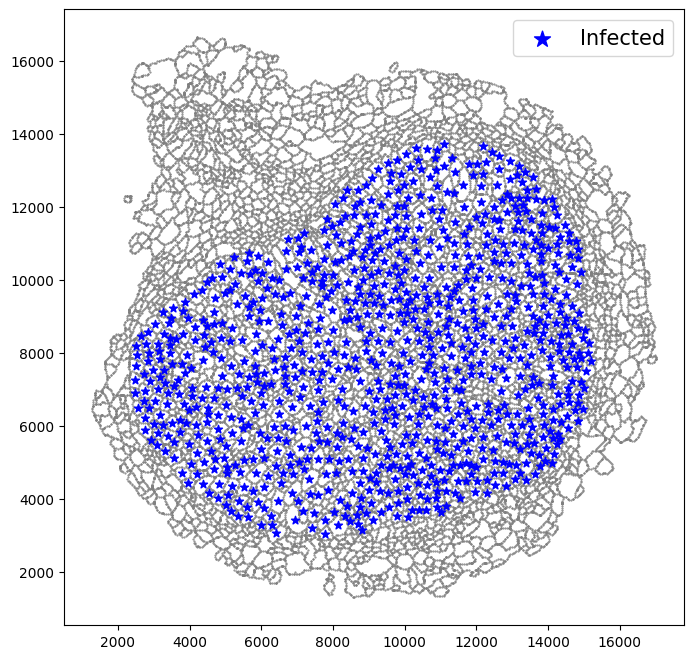

In [86]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax = np.atleast_1d(ax).ravel();

ax[0].scatter(wc[1], wc[0], c='gray', marker='.', s=1)
ax[0].scatter(metafocus[:,13], metafocus[:,14], c='blue', marker='*', label='Infected')
ax[0].legend(fontsize=15, markerscale=2);

In [47]:
bdh0, bdh1 = bottleneck_matrix(diag0, diag1, gd.bottleneck_distance)
bd_mtrx = np.maximum(bdh0, bdh1)
dflat = bd_mtrx[np.triu_indices(len(jsonfiles), k=1)]
filename = tsrc + transcriptomes[tidx] + '_-_' + level + 'level_bottleneck.csv'
pd.Series(dflat).to_csv(filename, index=False, header=None)

array([28.5, 30. , 14. , 32. , 34.5, 28.5, 32. , 21. , 34.5, 32. ])

In [8]:
pd.read_csv(filename, header=None)

,0
0,15.0
1,26.0
2,55.0
3,25.0
4,29.0
...,...
9040,56.0
9041,21.0
9042,23.5
9043,30.0
